Tarea S8.01. Visualitzacions en Python

Nivel 01

Conexión con la base de datos MySQL

In [1]:
#Importamos las librerías necesarias para manejar los datos y crear las gráficas:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Importamos las librerías necesarias para la conexión con la base de datos:

import mysql.connector
from mysql.connector import Error

Conectamos con la base de datos 'transactions_alex' en MySQL Workbench:

In [3]:
from sqlalchemy import create_engine

#Definimos las variables con las credenciales de la base de datos:
usuario = 'root'
clave = 'root'
host = 'localhost'
db = 'transactions_alex'

#Importamos los datos de nuestra base de datos:
try:
    db_transactions = mysql.connector.connect(host = host,
                                         database = db,
                                         user = usuario,
                                         password = clave)
    
    #Nos aseguramos de que se realiza la conexión con MySQL Server y con la base de datos:
    if db_transactions.is_connected():
        db_Info = db_transactions.get_server_info()
        print(f"Conectado con la version {db_Info} de MySQL Server")
        cursor = db_transactions.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print(f"Conexión establecida con la base de datos {record[0]}")

    #Recuperamos el nombre de las tablas de la base de datos y los guardamos en una lista:
    query_tablas = """SHOW tables"""
    cursor.execute(query_tablas)
    db_tablas = cursor.fetchall()
    
    lista_tablas = []
    for tabla in db_tablas:
        lista_tablas.append(tabla[0])

    #Vamos a cargar la información de cada tabla en sendos dataframes y crearemos un diccionario
    #cuyas claves serán los nombres de las tablas almacenadas en la lista y sus valores, el dataframe correspondiente a cada tabla:
    conexion = create_engine(f'mysql+mysqlconnector://{usuario}:{clave}@{host}/{db}')
    dataframe = {}

    for tabla in lista_tablas:
        query = f"SELECT * FROM {tabla}"
        dataframe[tabla] = pd.read_sql(query, conexion)

    #Comprobamos que hemos cargado correctamente el diccionario
    for tabla in lista_tablas:
        print(f'Tabla {tabla}: \n', dataframe[tabla].head(), '\n')

#Manejamos los posibles errores de sesión
except Error as e:
    print("Error en la conexión a MySQL:", e)
    
#Cerramos el cursor y la conexión    
finally:
    if db_transactions.is_connected():
        cursor.close()
        db_transactions.close()
        print("Conexión a MySQL cerrada")

Conectado con la version 8.0.28 de MySQL Server
Conexión establecida con la base de datos transactions_alex
Tabla company: 
        id                 company_name           phone  \
0  b-2222    Ac Fermentum Incorporated  06 85 56 52 33   
1  b-2226     Magna A Neque Industries  04 14 44 64 62   
2  b-2230                  Fusce Corp.  08 14 97 58 85   
3  b-2234    Convallis In Incorporated  06 66 57 29 50   
4  b-2238  Ante Iaculis Nec Foundation  08 23 04 99 53   

                              email        country  \
0  donec.porttitor.tellus@yahoo.net        Germany   
1       risus.donec.nibh@icloud.org      Australia   
2              risus@protonmail.edu  United States   
3                mauris.ut@aol.couk        Germany   
4       sed.dictum.proin@outlook.ca    New Zealand   

                          website  
0      https://instagram.com/site  
1    https://whatsapp.com/group/9  
2  https://pinterest.com/sub/cars  
3        https://cnn.com/user/110  
4    https://netflix.

Observamos que en la tabla product el precio está en formato texto y precedido por el símbolo $. Vamos a transformarlo a numérico.

In [4]:
df_product = dataframe['product']
df_product['price'] = df_product['price'].str.replace('$','')
df_product['price'] = df_product['price'].astype(float)
df_product.head(10)

,id,product_name,price,colour,wheight,warehouse_id
0,1,Direwolf Stannis,161.11,#7c7c7c,1.0,WH-4
1,10,Karstark Dorne,119.52,#f4f4f4,2.4,WH--5
2,100,south duel,40.43,#6d6d6d,3.0,WH--95
3,11,Karstark Dorne,49.70,#141414,2.7,WH--6
4,12,duel Direwolf,181.60,#a8a8a8,2.1,WH--7
5,13,palpatine chewbacca,139.59,#2b2b2b,1.0,WH--8
6,14,Direwolf,147.53,#c4c4c4,2.0,WH--9
7,15,Stannis warden,194.29,#dbdbdb,1.5,WH--10
8,16,the duel warden,180.91,#666666,3.0,WH--11
9,17,skywalker ewok sith,91.89,#7c7c7c,3.2,WH--12


Ejercicio 1

Gráfico con una variable numérica

Vamos a analizar el número de operaciones según rango de importes para aquellas transacciones efectivas (declined = 0)

In [5]:
#Para facilitar la lectura, definiremos los dataframes de cada tabla haciendo referencia a su clave en el diccionario de dataframes. Empezamos con la tabla 'transaction'  
df_transaction = dataframe['transaction']

#Queremos ver la distribución de los datos numéricos de la tabla:
df_transaction_ok = df_transaction[df_transaction['declined'] == 0]
df_transaction_ok.describe()

,timestamp,amount,declined,latitude,longitude
count,500,500.00000,500.0,500.000000,500.000000
mean,2021-09-10 10:45:47.573999872,259.01118,0.0,0.449181,-4.356967
min,2021-03-17 02:55:49,15.05000,0.0,-89.824800,-179.366000
25%,2021-06-11 09:47:49,136.19250,0.0,-44.190900,-100.175500
50%,2021-09-04 14:13:29,262.47000,0.0,0.152780,-5.848405
75%,2021-12-16 19:01:35,390.84750,0.0,45.005125,87.920300
max,2022-03-16 14:01:36,499.23000,0.0,89.921200,179.950000
std,NaN,143.13700,0.0,51.665107,106.374824


In [6]:
#Vamos a sacar algunas estadísticas sobre los ingresos y a graficarlas:
amount = df_transaction_ok['amount']

media = amount.mean()
mediana = amount.median()
percentil_25 = np.percentile(amount,25)
percentil_75 = np.percentile(amount,75)

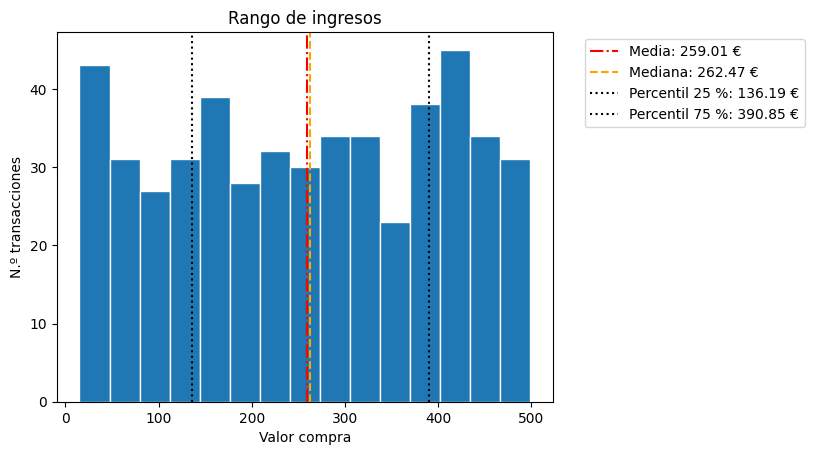

In [7]:
fig, ax = plt.subplots()

ax.hist(amount, bins=15, edgecolor="white")
ax.axvline(media, color="red", ls="-.", label=f"Media: {round(media,2)} €")
ax.axvline(mediana, color="orange", ls="--", label=f"Mediana: {round(mediana,2)} €")
ax.axvline(percentil_25, color="black", ls=":", label=f"Percentil 25 %: {round(percentil_25,2)} €")
ax.axvline(percentil_75, color="black", ls=":", label=f"Percentil 75 %: {round(percentil_75,2)} €")
ax.set_title('Rango de ingresos')
ax.set_xlabel('Valor compra')
ax.set_ylabel('N.º transacciones')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Vemos que no hay mucha diferencia entre el valor medio de los importes de las transacciones y la mediana; apenas una pequeña tendencia hacia transacciones de bajo importe, como se ve en la izquierda de la gráfica, compensado por una distribución homogénea entre 150 y 350 euros, y una elevada cantidad de transacciones por encima de los 400 euros.

Interesaría, por un lado, fidelizar a los clientes con compras más elevadas, ofreciendo ofertas u abonos para animar a adquirir más productos, y, por otro lado, promocionar los artículos más caros para aumentar el tícket de las posibles compras puntuales. 

Ejercicio 2

Gráfico con dos variables numéricas

Queremos visualizar los patrones de compra por edad.

In [8]:
#Vamos a calcular la edad de los usuarios y a añadirla al dataframe 'user':
from datetime import date
from datetime import datetime

df_usuario = dataframe['user']
df_usuario.head(10)

,id,name,surname,phone,email,birth_date,country,city,postal_code,address
0,1,Zeus,Gamble,1-282-581-0551,interdum.enim@protonmail.edu,"Nov 17, 1985",United States,Lowell,73544,348-7818 Sagittis St.
1,10,Robert,Mccarthy,(324) 746-6771,fermentum@protonmail.com,"Apr 30, 1984",United States,Eugene,85526,"P.O. Box 773, 3594 Ornare St."
2,100,Melodie,Mclean,1-677-221-7152,risus.varius@google.ca,"Sep 15, 1989",United States,College,11838,Ap #644-8492 Sagittis St.
3,101,Sarah,Beck,(358) 691-4345,vitae.risus@aol.couk,"Apr 9, 1983",United States,Great Falls,67129,"665-9047 In, Rd."
4,102,Jasper,Landry,1-397-765-1118,consectetuer.euismod@aol.org,"Apr 16, 1982",United States,Columbus,11595,Ap #374-7325 Sodales Rd.
5,103,Upton,Chavez,(227) 785-6484,euismod.est@aol.ca,"Mar 15, 1986",United States,Essex,95631,"1990 Vel, Av."
6,104,Martha,Barlow,(732) 326-5448,vulputate@hotmail.net,"Oct 29, 1988",United States,Chicago,41512,Ap #311-7103 In Avenue
7,105,Hashim,Rose,(858) 313-6727,urna@icloud.com,"Mar 28, 1983",United States,Tacoma,99632,"8034 Tortor, Road"
8,106,Tanner,Valenzuela,1-346-421-3135,nascetur.ridiculus@google.net,"Apr 6, 1993",United States,Naperville,31130,Ap #114-2616 Fusce Road
9,107,Victor,Valencia,(239) 569-1938,non.enim@hotmail.couk,"May 1, 1998",United States,Warren,15158,Ap #182-9926 At St.


In [9]:
#Transformamos la fecha de nacimiento a formato datetime
df_usuario['birth_date'] = pd.to_datetime(df_usuario['birth_date'])
df_usuario.head(10)


,id,name,surname,phone,email,birth_date,country,city,postal_code,address
0,1,Zeus,Gamble,1-282-581-0551,interdum.enim@protonmail.edu,1985-11-17,United States,Lowell,73544,348-7818 Sagittis St.
1,10,Robert,Mccarthy,(324) 746-6771,fermentum@protonmail.com,1984-04-30,United States,Eugene,85526,"P.O. Box 773, 3594 Ornare St."
2,100,Melodie,Mclean,1-677-221-7152,risus.varius@google.ca,1989-09-15,United States,College,11838,Ap #644-8492 Sagittis St.
3,101,Sarah,Beck,(358) 691-4345,vitae.risus@aol.couk,1983-04-09,United States,Great Falls,67129,"665-9047 In, Rd."
4,102,Jasper,Landry,1-397-765-1118,consectetuer.euismod@aol.org,1982-04-16,United States,Columbus,11595,Ap #374-7325 Sodales Rd.
5,103,Upton,Chavez,(227) 785-6484,euismod.est@aol.ca,1986-03-15,United States,Essex,95631,"1990 Vel, Av."
6,104,Martha,Barlow,(732) 326-5448,vulputate@hotmail.net,1988-10-29,United States,Chicago,41512,Ap #311-7103 In Avenue
7,105,Hashim,Rose,(858) 313-6727,urna@icloud.com,1983-03-28,United States,Tacoma,99632,"8034 Tortor, Road"
8,106,Tanner,Valenzuela,1-346-421-3135,nascetur.ridiculus@google.net,1993-04-06,United States,Naperville,31130,Ap #114-2616 Fusce Road
9,107,Victor,Valencia,(239) 569-1938,non.enim@hotmail.couk,1998-05-01,United States,Warren,15158,Ap #182-9926 At St.


In [10]:
#Calculamos la edad restando de Timestamp('now') la cantidad de días de cada usuario y dividiendo por el número de días/año, y lo añadimos a la tabla:
df_usuario['age'] = (pd.Timestamp('now') - df_usuario['birth_date']).dt.days // 365
df_usuario.head(10)

,id,name,surname,phone,email,birth_date,country,city,postal_code,address,age
0,1,Zeus,Gamble,1-282-581-0551,interdum.enim@protonmail.edu,1985-11-17,United States,Lowell,73544,348-7818 Sagittis St.,39
1,10,Robert,Mccarthy,(324) 746-6771,fermentum@protonmail.com,1984-04-30,United States,Eugene,85526,"P.O. Box 773, 3594 Ornare St.",40
2,100,Melodie,Mclean,1-677-221-7152,risus.varius@google.ca,1989-09-15,United States,College,11838,Ap #644-8492 Sagittis St.,35
3,101,Sarah,Beck,(358) 691-4345,vitae.risus@aol.couk,1983-04-09,United States,Great Falls,67129,"665-9047 In, Rd.",41
4,102,Jasper,Landry,1-397-765-1118,consectetuer.euismod@aol.org,1982-04-16,United States,Columbus,11595,Ap #374-7325 Sodales Rd.,42
5,103,Upton,Chavez,(227) 785-6484,euismod.est@aol.ca,1986-03-15,United States,Essex,95631,"1990 Vel, Av.",38
6,104,Martha,Barlow,(732) 326-5448,vulputate@hotmail.net,1988-10-29,United States,Chicago,41512,Ap #311-7103 In Avenue,36
7,105,Hashim,Rose,(858) 313-6727,urna@icloud.com,1983-03-28,United States,Tacoma,99632,"8034 Tortor, Road",41
8,106,Tanner,Valenzuela,1-346-421-3135,nascetur.ridiculus@google.net,1993-04-06,United States,Naperville,31130,Ap #114-2616 Fusce Road,31
9,107,Victor,Valencia,(239) 569-1938,non.enim@hotmail.couk,1998-05-01,United States,Warren,15158,Ap #182-9926 At St.,26


In [11]:
#Vamos a hacer una join entre los dataframes 'transaction' y 'user'. Para evitar sufijos en los campos de las columnas, renombramos la columna id de user previo a la join:
df_usuario = df_usuario.rename(columns={'id': 'user_id'})
df_usuario.head(10)

,user_id,name,surname,phone,email,birth_date,country,city,postal_code,address,age
0,1,Zeus,Gamble,1-282-581-0551,interdum.enim@protonmail.edu,1985-11-17,United States,Lowell,73544,348-7818 Sagittis St.,39
1,10,Robert,Mccarthy,(324) 746-6771,fermentum@protonmail.com,1984-04-30,United States,Eugene,85526,"P.O. Box 773, 3594 Ornare St.",40
2,100,Melodie,Mclean,1-677-221-7152,risus.varius@google.ca,1989-09-15,United States,College,11838,Ap #644-8492 Sagittis St.,35
3,101,Sarah,Beck,(358) 691-4345,vitae.risus@aol.couk,1983-04-09,United States,Great Falls,67129,"665-9047 In, Rd.",41
4,102,Jasper,Landry,1-397-765-1118,consectetuer.euismod@aol.org,1982-04-16,United States,Columbus,11595,Ap #374-7325 Sodales Rd.,42
5,103,Upton,Chavez,(227) 785-6484,euismod.est@aol.ca,1986-03-15,United States,Essex,95631,"1990 Vel, Av.",38
6,104,Martha,Barlow,(732) 326-5448,vulputate@hotmail.net,1988-10-29,United States,Chicago,41512,Ap #311-7103 In Avenue,36
7,105,Hashim,Rose,(858) 313-6727,urna@icloud.com,1983-03-28,United States,Tacoma,99632,"8034 Tortor, Road",41
8,106,Tanner,Valenzuela,1-346-421-3135,nascetur.ridiculus@google.net,1993-04-06,United States,Naperville,31130,Ap #114-2616 Fusce Road,31
9,107,Victor,Valencia,(239) 569-1938,non.enim@hotmail.couk,1998-05-01,United States,Warren,15158,Ap #182-9926 At St.,26


In [12]:
df_transaction_user = pd.merge(df_transaction, df_usuario, on='user_id', how='inner')
df_transaction_user.head()

,id,credit_card_id,company_id,timestamp,amount,declined,product_ids,user_id,latitude,longitude,name,surname,phone,email,birth_date,country,city,postal_code,address,age
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,CcU-2938,b-2362,2021-08-28 23:42:24,466.92,0,"71, 1, 19",92,81.9185,-12.5276,Lynn,Riddle,1-387-885-4057,vitae.aliquet@outlook.edu,1984-09-21,United States,Bozeman,61871,"P.O. Box 712, 7907 Est St.",40
1,0466A42E-47CF-8D24-FD01-C0B689713128,CcU-4219,b-2302,2021-07-26 07:29:18,49.53,0,"47, 97, 43",170,-43.9695,-117.5250,William,Benjamin,0800 1111,porttitor@icloud.ca,1987-05-15,United Kingdom,Coldstream,KY0 0DY,662-8112 Praesent Av.,37
2,063FBA79-99EC-66FB-29F7-25726D1764A5,CcU-2987,b-2250,2022-01-06 21:25:27,92.61,0,"47, 67, 31, 5",275,-81.2227,-129.0500,Kenyon,Hartman,082-871-7248,convallis.ante.lectus@yahoo.com,1982-08-03,Canada,Richmond,R8H 2K2,8564 Facilisi. St.,42
3,0668296C-CDB9-A883-76BC-2E4C44F8C8AE,CcU-3743,b-2618,2022-01-26 02:07:14,394.18,0,"89, 83, 79",265,-34.3593,-100.5560,Chloe,Keith,022-178-1548,arcu.eu@protonmail.org,1999-01-10,Canada,Oliver,B5T 7L6,"P.O. Box 289, 3192 Cursus St.",26
4,06CD9AA5-9B42-D684-DDDD-A5E394FEBA99,CcU-2959,b-2346,2021-10-26 23:00:01,279.93,0,"43, 31",92,33.7381,158.2980,Lynn,Riddle,1-387-885-4057,vitae.aliquet@outlook.edu,1984-09-21,United States,Bozeman,61871,"P.O. Box 712, 7907 Est St.",40


Text(0.5, 1.0, 'Importe transacciones por edad')

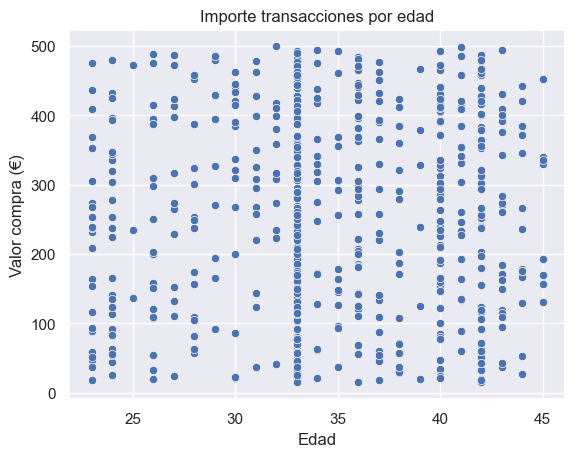

In [13]:
sns.set_theme(style="darkgrid")
sns.scatterplot(y=df_transaction_user['amount'], x=df_transaction_user['age'])
plt.xlabel('Edad')
plt.ylabel('Valor compra (€)')
plt.title('Importe transacciones por edad')

Vemos que no hay ninguna correlación aparente entre la edad de los compradores y el importe, ya que los puntos aparecen muy dispersos.

La cantidad de puntos para los usuarios de 33 años nos hace sospechar que quizá haya un usuario muy activo con esta edad. Ejecutamos un par de consultas a continuación.

In [14]:
df_transaction_user[df_transaction_user['age']==33]


,id,credit_card_id,company_id,timestamp,amount,declined,product_ids,user_id,latitude,longitude,name,surname,phone,email,birth_date,country,city,postal_code,address,age
5,07A46D48-31A3-7E87-65B9-0DA902AD109F,CcU-3225,b-2386,2021-06-28 21:11:42,340.87,1,"47, 23",272,38.83420,92.1905,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33
8,0BEB80B7-9D66-1707-CE4B-9DC7E71914B5,CcU-3141,b-2338,2022-03-04 14:54:35,288.81,1,"19, 41, 29, 3",272,23.32640,-13.6037,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33
9,0C7C3A33-9947-3BC1-846D-7BE3D0D17598,CcU-3309,b-2434,2021-04-10 20:58:41,103.44,1,"89, 31",272,63.36150,-68.6667,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33
12,1017AA59-3D5F-7A4C-1992-D151A8D1FA0A,CcU-3701,b-2618,2021-11-01 01:02:11,447.11,0,"37, 13",267,4.27645,-101.5540,Ocean,Nelson,079-481-2745,aenean@yahoo.com,1991-12-26,Canada,Charlottetown,85X 3P4,"Ap #732-8357 Pede, Rd.",33
15,10A9B07A-810C-76EB-4D15-12C6CC128037,CcU-3155,b-2346,2021-05-16 21:00:28,27.85,1,"43, 83",272,-32.05560,-76.7281,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,F28E106B-5418-4667-9514-2E2A823ECC65,CcU-3358,b-2462,2022-03-05 06:54:37,114.89,1,"79, 47, 97",272,-55.94960,-11.6066,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33
577,FA053936-75D8-85FA-490D-9B624E1B920A,CcU-3197,b-2370,2021-07-06 10:18:35,151.32,0,"37, 5",272,-75.14150,139.1820,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33
578,FAAD3FFC-1A17-E141-43D3-359A5BA7CB3B,CcU-3183,b-2362,2021-10-24 20:16:23,149.84,0,"2, 13, 5, 19",272,59.48720,129.9640,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33
580,FBD7E0D6-BA6B-F5BC-0CA9-EA4B8760100C,CcU-3281,b-2418,2021-04-29 14:17:50,207.09,1,"97, 83, 29",272,83.67560,-77.4352,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33


In [15]:
df_transaction_user[df_transaction_user['surname']=='Gilbert']

,id,credit_card_id,company_id,timestamp,amount,declined,product_ids,user_id,latitude,longitude,name,surname,phone,email,birth_date,country,city,postal_code,address,age
5,07A46D48-31A3-7E87-65B9-0DA902AD109F,CcU-3225,b-2386,2021-06-28 21:11:42,340.87,1,"47, 23",272,38.8342,92.1905,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33
8,0BEB80B7-9D66-1707-CE4B-9DC7E71914B5,CcU-3141,b-2338,2022-03-04 14:54:35,288.81,1,"19, 41, 29, 3",272,23.3264,-13.6037,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33
9,0C7C3A33-9947-3BC1-846D-7BE3D0D17598,CcU-3309,b-2434,2021-04-10 20:58:41,103.44,1,"89, 31",272,63.3615,-68.6667,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33
15,10A9B07A-810C-76EB-4D15-12C6CC128037,CcU-3155,b-2346,2021-05-16 21:00:28,27.85,1,"43, 83",272,-32.0556,-76.7281,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33
20,13DCC69F-EA07-E52B-8309-D474C6281E80,CcU-3197,b-2370,2021-06-02 04:10:57,50.09,1,"97, 29, 23",272,32.3746,165.0160,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,F28E106B-5418-4667-9514-2E2A823ECC65,CcU-3358,b-2462,2022-03-05 06:54:37,114.89,1,"79, 47, 97",272,-55.9496,-11.6066,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33
577,FA053936-75D8-85FA-490D-9B624E1B920A,CcU-3197,b-2370,2021-07-06 10:18:35,151.32,0,"37, 5",272,-75.1415,139.1820,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33
578,FAAD3FFC-1A17-E141-43D3-359A5BA7CB3B,CcU-3183,b-2362,2021-10-24 20:16:23,149.84,0,"2, 13, 5, 19",272,59.4872,129.9640,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33
580,FBD7E0D6-BA6B-F5BC-0CA9-EA4B8760100C,CcU-3281,b-2418,2021-04-29 14:17:50,207.09,1,"97, 83, 29",272,83.6756,-77.4352,Hedwig,Gilbert,064-204-8788,sem.eget@icloud.edu,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33


Vemos que el usuario Hedwig Gilbert ha realizado 76 compras durante el periodo. Vamos a volver a dibujar la gráfica de dispersión excluyendo a este comprador y, de paso, rotamos los ejes para una mejor visualización:

Text(0.5, 1.0, 'Importe transacciones por edad')

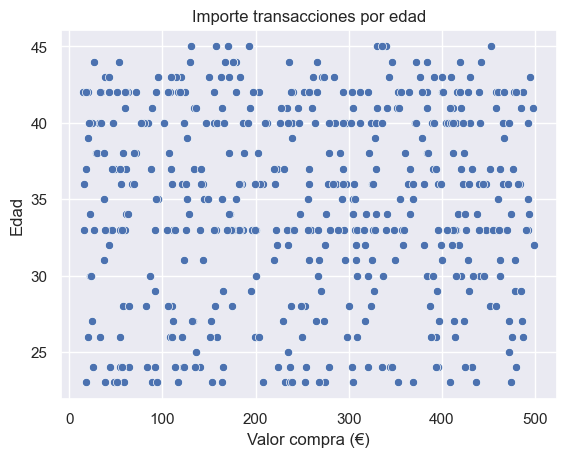

In [16]:
sns.scatterplot(x=df_transaction_user[df_transaction_user['surname']!='Gilbert'].amount, y=df_transaction_user['age'])
plt.ylabel('Edad')
plt.xlabel('Valor compra (€)')
plt.title('Importe transacciones por edad')

Ejercicio 3

Gráfico con una variable categórica

Vamos a ver cuántas empresas hay por país.

In [17]:
import squarify

df_company = dataframe['company']
df_company.head()


,id,company_name,phone,email,country,website
0,b-2222,Ac Fermentum Incorporated,06 85 56 52 33,donec.porttitor.tellus@yahoo.net,Germany,https://instagram.com/site
1,b-2226,Magna A Neque Industries,04 14 44 64 62,risus.donec.nibh@icloud.org,Australia,https://whatsapp.com/group/9
2,b-2230,Fusce Corp.,08 14 97 58 85,risus@protonmail.edu,United States,https://pinterest.com/sub/cars
3,b-2234,Convallis In Incorporated,06 66 57 29 50,mauris.ut@aol.couk,Germany,https://cnn.com/user/110
4,b-2238,Ante Iaculis Nec Foundation,08 23 04 99 53,sed.dictum.proin@outlook.ca,New Zealand,https://netflix.com/settings


In [18]:
#Extraemos una serie de pandas al agrupar el número de empresas por la categoría país:
num_paises = df_company.groupby('country').count()['id'].sort_values(ascending=False)
num_paises

country
Sweden            11
Netherlands       10
Italy              9
United Kingdom     9
United States      9
Belgium            8
Germany            8
Norway             7
Australia          6
Ireland            6
New Zealand        6
Canada             5
France             3
China              2
Spain              1
Name: id, dtype: int64

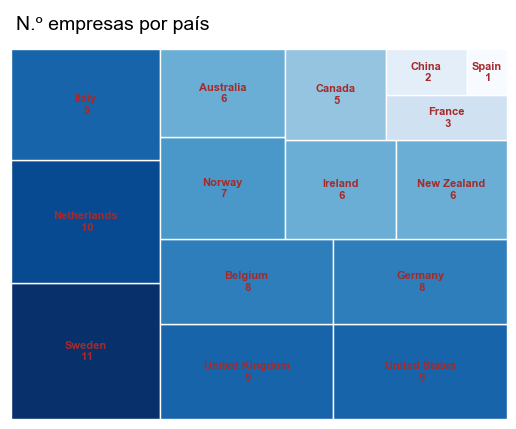

In [19]:
#Librerías para configurar el treemap
import matplotlib
from pypalettes import load_cmap
from highlight_text import fig_text

#Creamos las etiquetas que se sobreimpresionarán en cada cuadro:
etiquetas = [f"{pais}\n {num_empresas}" for pais, num_empresas in zip(num_paises.index, num_paises.values)]

#Escogemos la paleta de colores. Nos decantamos por un azul que se degradará del máximo al mínimo
cmap = matplotlib.cm.Blues
mini=min(num_paises.values)
maxi=max(num_paises.values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(valor)) for valor in num_paises]

squarify.plot(sizes=num_paises, label=etiquetas, color=colors, text_kwargs={
      'color':'brown',
      'fontsize':8,
      'fontweight':'bold'})
plt.axis('off')

fig_text(
   x=0.133, y=0.95,
   s='N.º empresas por país',
   color="black",
   fontsize=14,
   ha='left'
)

Los países con mayor número de empresas que operan con nosotros son Suecia, Países Bajos, Italia, Reino Unido y Estados Unidos.

Ejercicio 4

Gráfico con una variable categórica y una numérica

Vamos a estudiar la evolución de las transacciones y las ventas por periodo.

In [20]:
#Añadimos el periodo al dataframe 'transaction'
df_transaction['period'] = df_transaction['timestamp'].dt.to_period('M')
df_transaction.head()

,id,credit_card_id,company_id,timestamp,amount,declined,product_ids,user_id,latitude,longitude,period
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,CcU-2938,b-2362,2021-08-28 23:42:24,466.92,0,"71, 1, 19",92,81.9185,-12.5276,2021-08
1,0466A42E-47CF-8D24-FD01-C0B689713128,CcU-4219,b-2302,2021-07-26 07:29:18,49.53,0,"47, 97, 43",170,-43.9695,-117.5250,2021-07
2,063FBA79-99EC-66FB-29F7-25726D1764A5,CcU-2987,b-2250,2022-01-06 21:25:27,92.61,0,"47, 67, 31, 5",275,-81.2227,-129.0500,2022-01
3,0668296C-CDB9-A883-76BC-2E4C44F8C8AE,CcU-3743,b-2618,2022-01-26 02:07:14,394.18,0,"89, 83, 79",265,-34.3593,-100.5560,2022-01
4,06CD9AA5-9B42-D684-DDDD-A5E394FEBA99,CcU-2959,b-2346,2021-10-26 23:00:01,279.93,0,"43, 31",92,33.7381,158.2980,2021-10


In [21]:
#Agrupamos el importe de las transacciones (tanto válidas como rechazadas) por periodo:
transacciones_mensuales =  df_transaction['amount'].groupby([df_transaction['period']]).sum()
print(transacciones_mensuales)
transacciones_mensuales.describe()

period
2021-03     6471.66
2021-04    15980.23
2021-05    15364.17
2021-06    14241.19
2021-07    11373.93
2021-08    15608.04
2021-09    10503.32
2021-10    12281.17
2021-11     8888.91
2021-12    15162.07
2022-01     8990.02
2022-02    10941.42
2022-03     4897.62
Freq: M, Name: amount, dtype: float64


count       13.000000
mean     11592.596154
std       3612.692881
min       4897.620000
25%       8990.020000
50%      11373.930000
75%      15162.070000
max      15980.230000
Name: amount, dtype: float64

In [22]:
#Realizamos una agrupación similar solo para las transacciones aceptadas:
ventas_mensuales =  df_transaction_ok['amount'].groupby([df_transaction['period']]).sum()
print(ventas_mensuales)
ventas_mensuales.describe()

period
2021-03     5711.35
2021-04    13507.68
2021-05    11659.27
2021-06    10817.81
2021-07     9931.77
2021-08    13900.24
2021-09     9524.43
2021-10    10765.57
2021-11     7675.74
2021-12    14177.16
2022-01     8236.31
2022-02    10077.55
2022-03     3520.71
Freq: M, Name: amount, dtype: float64


count       13.000000
mean      9961.968462
std       3136.837340
min       3520.710000
25%       8236.310000
50%      10077.550000
75%      11659.270000
max      14177.160000
Name: amount, dtype: float64

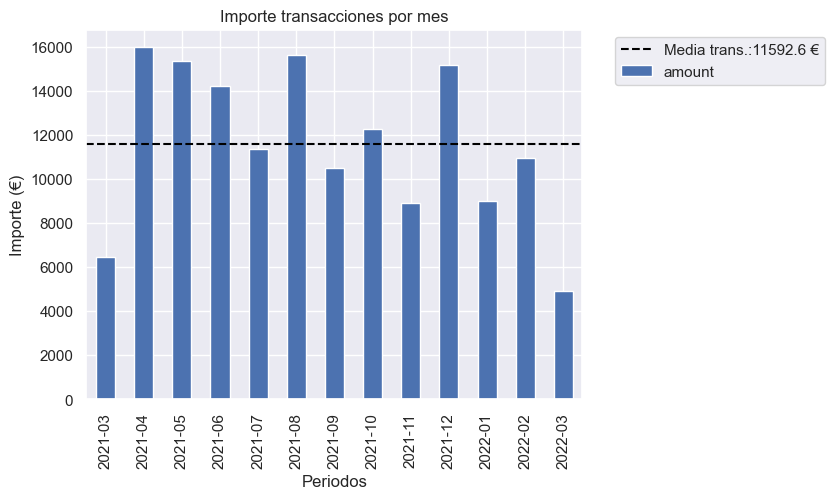

In [23]:
#Graficamos la evolución de los importes totales de las transacciones por periodo:
media_transacciones = transacciones_mensuales.mean()

ax = transacciones_mensuales.plot(kind='bar')
ax.axhline(y=media_transacciones, color='black', linestyle='--', label=f'Media trans.:{round(media_transacciones,2)} €')
ax.set_title('Importe transacciones por mes')
ax.set_ylabel('Importe (€)')
ax.set_xlabel('Periodos')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Los meses con mayor importe de transacciones realizadas corresponde a los meses de abril, agosto, mayo, diciembre, junio y septiembre del 2021, superando todos los 12.000 euros de importe. Pero, a continuación, vamos a ver qué importes se materializaron:

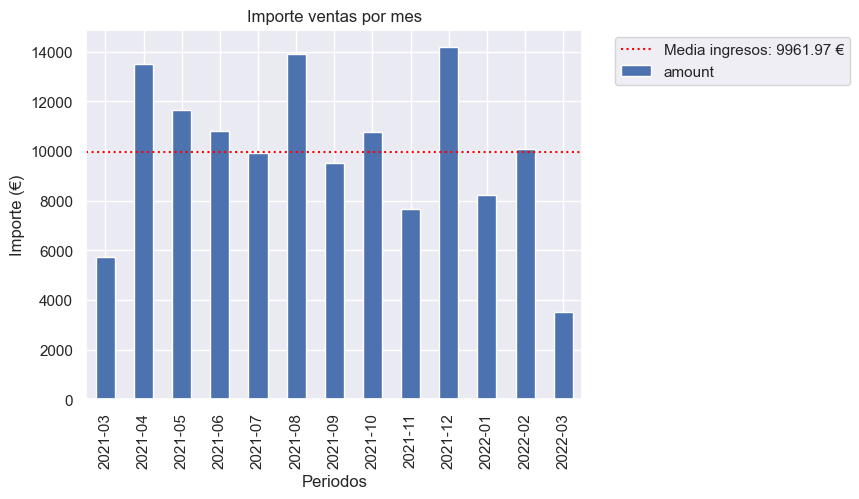

In [24]:
media_ventas = ventas_mensuales.mean()

ax = ventas_mensuales.plot(kind='bar')
ax.axhline(y=media_ventas, color='red', linestyle=':', label=f'Media ingresos: {round(media_ventas,2)} €')
ax.set_title('Importe ventas por mes')
ax.set_ylabel('Importe (€)')
ax.set_xlabel('Periodos')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

En los meses de abril y agosto se dejó de ingresar, a causa de las transacciones rechazadas, cerca de 2.000 euros; y el mes con mayores ingresos fue el mes de diciembre, que sufrió un menor impacto a causa de las transacciones rechazadas.

Si unimos ambas gráficas de barras en una sola gráfica (lo que implica añadir una variable categórica más, si la operación fue aceptada o declinada), podemos comprar mejor la diferencia.

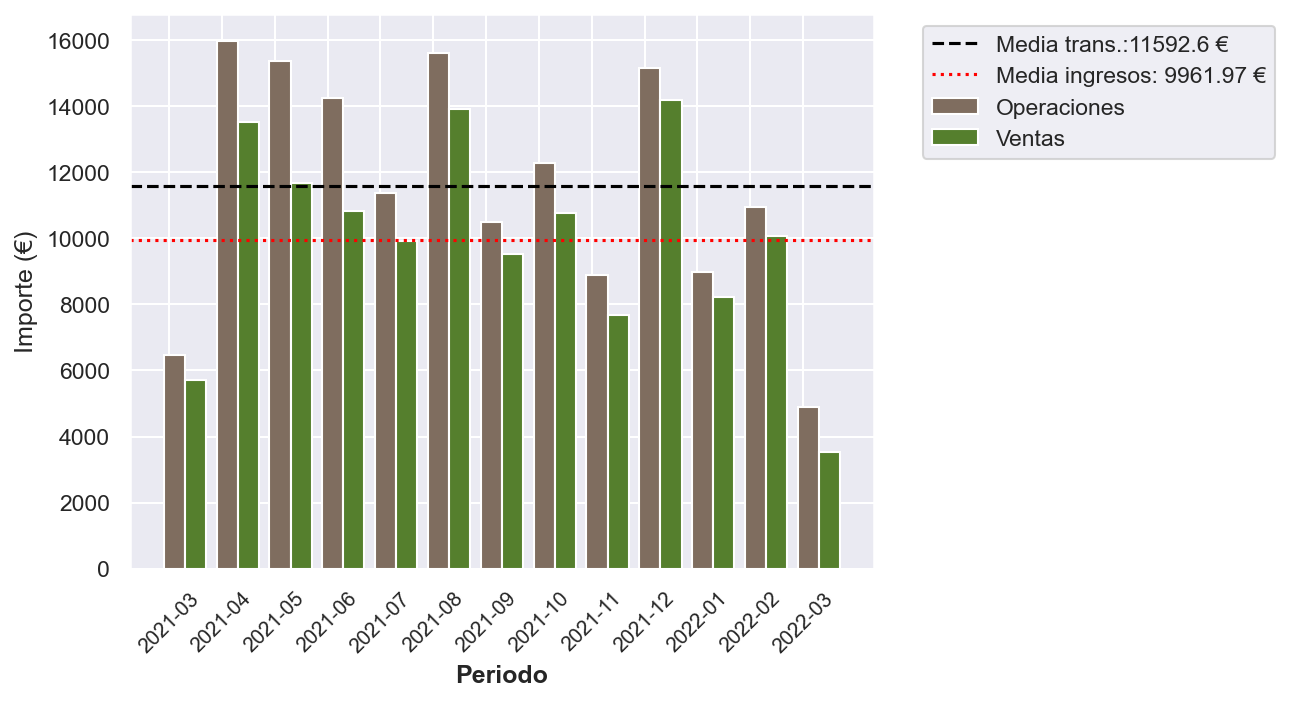

In [25]:
# Datos
barWidth = 0.4
bars1 = transacciones_mensuales.values
bars2 = ventas_mensuales.values


# Posición de las barras
r = np.arange(len(bars1))
r2 = r + barWidth

# Gráfica
fig, ax = plt.subplots(dpi=150)
ax.bar(r, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Operaciones')
ax.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Ventas')

# Xticks
ax.set_xlabel('Periodo', fontweight='bold')
ax.set_ylabel('Importe (€)')
ax.set_xticks(r + barWidth -0.5)
ax.set_xticklabels(transacciones_mensuales.index)
ax.tick_params(axis='x', labelrotation=45, labelsize='small')

# Medias
ax.axhline(y=media_transacciones, color='black', linestyle='--', label=f'Media trans.:{round(media_transacciones,2)} €')
ax.axhline(y=media_ventas, color='red', linestyle=':', label=f'Media ingresos: {round(media_ventas,2)} €')

# Legend
ax.legend(bbox_to_anchor=(1.05, 1), ncol=1, loc='upper left')

#ax.legend('Operaciones e ingresos por periodo')

Ejercicio 5

Gráfico con dos variables categóricas

Queremos saber cuántas transacciones realizan nuestros usuarios.

In [26]:
#Añadimos el campo 'full name' a la unión de los dataframes 'transaction' y 'user':
df_transaction_user['full_name'] = df_transaction_user['name'] + ' ' + df_transaction_user['surname']
df_transaction_user.head()

,id,credit_card_id,company_id,timestamp,amount,declined,product_ids,user_id,latitude,longitude,...,surname,phone,email,birth_date,country,city,postal_code,address,age,full_name
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,CcU-2938,b-2362,2021-08-28 23:42:24,466.92,0,"71, 1, 19",92,81.9185,-12.5276,...,Riddle,1-387-885-4057,vitae.aliquet@outlook.edu,1984-09-21,United States,Bozeman,61871,"P.O. Box 712, 7907 Est St.",40,Lynn Riddle
1,0466A42E-47CF-8D24-FD01-C0B689713128,CcU-4219,b-2302,2021-07-26 07:29:18,49.53,0,"47, 97, 43",170,-43.9695,-117.5250,...,Benjamin,0800 1111,porttitor@icloud.ca,1987-05-15,United Kingdom,Coldstream,KY0 0DY,662-8112 Praesent Av.,37,William Benjamin
2,063FBA79-99EC-66FB-29F7-25726D1764A5,CcU-2987,b-2250,2022-01-06 21:25:27,92.61,0,"47, 67, 31, 5",275,-81.2227,-129.0500,...,Hartman,082-871-7248,convallis.ante.lectus@yahoo.com,1982-08-03,Canada,Richmond,R8H 2K2,8564 Facilisi. St.,42,Kenyon Hartman
3,0668296C-CDB9-A883-76BC-2E4C44F8C8AE,CcU-3743,b-2618,2022-01-26 02:07:14,394.18,0,"89, 83, 79",265,-34.3593,-100.5560,...,Keith,022-178-1548,arcu.eu@protonmail.org,1999-01-10,Canada,Oliver,B5T 7L6,"P.O. Box 289, 3192 Cursus St.",26,Chloe Keith
4,06CD9AA5-9B42-D684-DDDD-A5E394FEBA99,CcU-2959,b-2346,2021-10-26 23:00:01,279.93,0,"43, 31",92,33.7381,158.2980,...,Riddle,1-387-885-4057,vitae.aliquet@outlook.edu,1984-09-21,United States,Bozeman,61871,"P.O. Box 712, 7907 Est St.",40,Lynn Riddle


In [27]:
#Contamos el número de transacciones por usuario y la serie resultante la transformamos en un dataframe:
compras_usuario =  df_transaction_user['id'].groupby([df_transaction_user['full_name']]).count().sort_values(ascending=False)
df_compras_usuario = compras_usuario.to_frame(name='num_transacciones')
df_compras_usuario


,num_transacciones
full_name,
Hedwig Gilbert,76
Ocean Nelson,52
Kenyon Hartman,48
Lynn Riddle,39
Brennan Wynn,25
...,...
Kimberley Avila,1
Kim Zimmerman,1
David Vance,1


In [28]:
#Vamos a echar un vistazo a los valores, porque sospechamos que tendremos usuarios que realizan compras esporádicamente:
df_compras_usuario.values

array([[76],
       [52],
       [48],
       [39],
       [25],
       [22],
       [17],
       [ 5],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 4],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],
       [ 2],

In [29]:
df_compras_usuario['num_transacciones'].info()

<class 'pandas.core.series.Series'>
Index: 216 entries, Hedwig Gilbert to Acton Gallegos
Series name: num_transacciones
Non-Null Count  Dtype
--------------  -----
216 non-null    int64
dtypes: int64(1)
memory usage: 3.4+ KB


In [30]:
#Vamos a calcular el número total de transacciones, el número de usuarios que han realizado más de dos transacciones y el número de usuarios con 1 o 2 transacciones:
df_compras_usuario['num_transacciones'].sum()

587

In [31]:
df_compras_usuario[df_compras_usuario['num_transacciones']>2].sum()

num_transacciones    308
dtype: int64

In [32]:
suma_resto_usuarios =df_compras_usuario[df_compras_usuario['num_transacciones']<=2].sum()
suma_resto_usuarios


num_transacciones    279
dtype: int64

In [33]:
#Vamos a filtrar el dataframe con los usuarios que han hecho más de dos operaciones, y el resto los unificaremos en la línea 'Resto usuarios'
df_compras_usuario_filtrado = df_compras_usuario[df_compras_usuario['num_transacciones']>2]
df_compras_usuario_filtrado.loc['Resto usuarios'] = suma_resto_usuarios
df_compras_usuario_filtrado

/var/folders/zd/c44thsy53rq3c4k8x7lqbfdh0000gn/T/ipykernel_4321/3007069505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compras_usuario_filtrado.loc['Resto usuarios'] = suma_resto_usuarios


,num_transacciones
full_name,
Hedwig Gilbert,76
Ocean Nelson,52
Kenyon Hartman,48
Lynn Riddle,39
Brennan Wynn,25
Slade Poole,22
Kim Mooney,17
Neil Powers,5
Clark Olson,4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pywaffle/waffle.py:283: PendingDeprecationWarning: The set_tight_layout function will be deprecated in a future version. Use set_layout_engine instead.
  self.set_tight_layout(self.fig_args["tight"])


Text(0.5, 1.0, 'Operaciones por usuario')

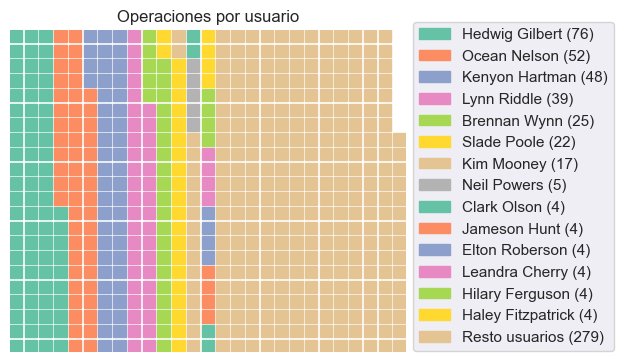

In [34]:
#Vamos a representar estos valores en un mosaico

from pywaffle import Waffle

plt.figure(
  FigureClass=Waffle,
  rows=22,
  values=df_compras_usuario_filtrado['num_transacciones'],
  labels=[f"{name} ({value})" for name, value in df_compras_usuario_filtrado['num_transacciones'].items()],
  legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1.05)}
)

plt.title('Operaciones por usuario')

Ejercicio 6

Gráfico con tres variables

Vamos a ver las estadísticas de ventas por país y por tipo de transacción (aceptada o declinada)

In [35]:
#Unimos los dataframes 'transaction' y 'company'
df_company.rename(columns={'id': 'company_id'}, inplace=True)
df_transaction_country = pd.merge(df_transaction, df_company, on='company_id', how='inner')
df_transaction_country.head()

,id,credit_card_id,company_id,timestamp,amount,declined,product_ids,user_id,latitude,longitude,period,company_name,phone,email,country,website
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,CcU-2938,b-2362,2021-08-28 23:42:24,466.92,0,"71, 1, 19",92,81.9185,-12.5276,2021-08,Lorem Eu Incorporated,01 83 66 62 07,enim.gravida.sit@hotmail.net,Canada,https://baidu.com/en-ca
1,0466A42E-47CF-8D24-FD01-C0B689713128,CcU-4219,b-2302,2021-07-26 07:29:18,49.53,0,"47, 97, 43",170,-43.9695,-117.5250,2021-07,Nunc Interdum Incorporated,05 18 15 48 13,non@outlook.com,Germany,https://wikipedia.org/en-us
2,063FBA79-99EC-66FB-29F7-25726D1764A5,CcU-2987,b-2250,2022-01-06 21:25:27,92.61,0,"47, 67, 31, 5",275,-81.2227,-129.0500,2022-01,Amet Nulla Donec Corporation,07 15 25 14 74,mattis.integer.eu@protonmail.net,Italy,https://netflix.com/sub/cars
3,0668296C-CDB9-A883-76BC-2E4C44F8C8AE,CcU-3743,b-2618,2022-01-26 02:07:14,394.18,0,"89, 83, 79",265,-34.3593,-100.5560,2022-01,Non Institute,06 77 15 31 14,amet.metus@protonmail.couk,United Kingdom,https://guardian.co.uk/settings
4,06CD9AA5-9B42-D684-DDDD-A5E394FEBA99,CcU-2959,b-2346,2021-10-26 23:00:01,279.93,0,"43, 31",92,33.7381,158.2980,2021-10,Ut Semper Foundation,01 60 36 33 06,consectetuer@google.ca,Sweden,https://ebay.com/settings


In [36]:
#Contamos el número de operaciones por país:
countries_agrup = df_transaction_country['id'].groupby(df_transaction_country['country']).count().sort_values(ascending=False)
countries_agrup


country
Germany           118
United Kingdom    100
Sweden             79
Norway             68
Ireland            62
Canada             61
Netherlands        18
Italy              17
United States      17
Belgium            13
Australia          12
New Zealand        11
France              6
China               3
Spain               2
Name: id, dtype: int64

In [37]:
#Vamos a limitar la gráfica a los países con más de 20 operaciones, porque consideramos que la gráfica distorsiona los resultados para países con menos números de operaciones
countries_top = countries_agrup[countries_agrup > 20]
countries_top

country
Germany           118
United Kingdom    100
Sweden             79
Norway             68
Ireland            62
Canada             61
Name: id, dtype: int64

In [38]:
df_transaction_country_top = df_transaction_country[df_transaction_country['country'].isin(countries_top.index)]
df_transaction_country_top.head()

,id,credit_card_id,company_id,timestamp,amount,declined,product_ids,user_id,latitude,longitude,period,company_name,phone,email,country,website
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,CcU-2938,b-2362,2021-08-28 23:42:24,466.92,0,"71, 1, 19",92,81.9185,-12.5276,2021-08,Lorem Eu Incorporated,01 83 66 62 07,enim.gravida.sit@hotmail.net,Canada,https://baidu.com/en-ca
1,0466A42E-47CF-8D24-FD01-C0B689713128,CcU-4219,b-2302,2021-07-26 07:29:18,49.53,0,"47, 97, 43",170,-43.9695,-117.5250,2021-07,Nunc Interdum Incorporated,05 18 15 48 13,non@outlook.com,Germany,https://wikipedia.org/en-us
3,0668296C-CDB9-A883-76BC-2E4C44F8C8AE,CcU-3743,b-2618,2022-01-26 02:07:14,394.18,0,"89, 83, 79",265,-34.3593,-100.5560,2022-01,Non Institute,06 77 15 31 14,amet.metus@protonmail.couk,United Kingdom,https://guardian.co.uk/settings
4,06CD9AA5-9B42-D684-DDDD-A5E394FEBA99,CcU-2959,b-2346,2021-10-26 23:00:01,279.93,0,"43, 31",92,33.7381,158.2980,2021-10,Ut Semper Foundation,01 60 36 33 06,consectetuer@google.ca,Sweden,https://ebay.com/settings
6,09DE92CE-6F27-2BB7-13B5-9385B2B3B8E2,CcU-3071,b-2298,2021-05-11 20:40:06,303.05,1,"67, 7",275,71.1706,10.5757,2021-05,Elit Etiam Laoreet Associates,07 69 74 17 45,ultrices@google.couk,Canada,https://yahoo.com/fr


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


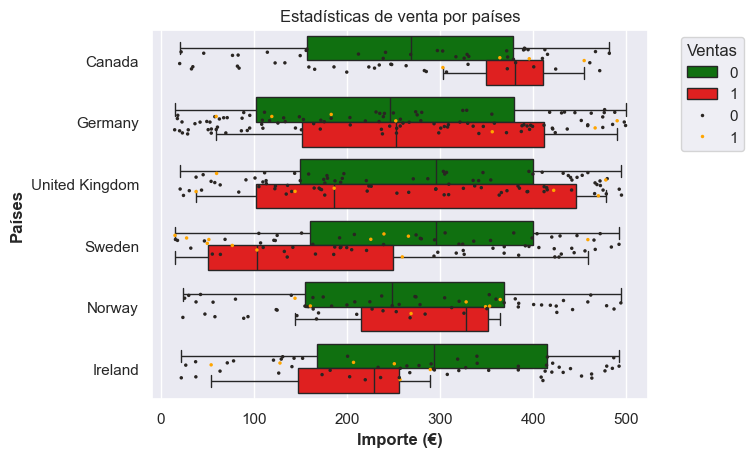

In [39]:
#Graficamos un boxplot para analizar las estadísticas por país y tipo de operación. Por encima, marcamos las operaciones por país para tener una referencia visual de la cantidad de operaciones de cada país:
custom_palette = {0: "green", 1: "red"}
sns.boxplot(y=df_transaction_country_top['country'], x=df_transaction_country_top['amount'], hue=df_transaction_country_top['declined'], palette=custom_palette)

# Añadimos un stripplot:
ax = sns.stripplot(y='country', x='amount', hue='declined', data=df_transaction_country_top, palette="dark:orange", jitter=0.2, size=2.5)

plt.title("Estadísticas de venta por países", loc="center")
ax.set_ylabel('Países', fontweight='bold')
ax.set_xlabel('Importe (€)', fontweight='bold')

plt.legend(bbox_to_anchor=(1.05, 1), ncol=1, loc='upper left', title='Ventas')

Vemos que Alemania es el país con mayor número de transacciones. La mediana de sus transacciones es, junto a la de Noruega, de las más bajas, pero la distribución de importes, tanto en el interpercentil como el rango absoluto, es el más amplio. También en el caso de las transacciones declinadas, que, aunque no sean muchas, si se trabaja para corregir las causas, influiría muy positivamente en el balance.

En el caso de Canadá, vemos que las transacciones declinadas ocurren en operaciones importantes.

Irlanda es el país cuyas operaciones nos proporcionan mayor rendimiento.


Ejercicio 7

Graficar un pairplot

Vamos a analizar las transacciones por importe, número de productos y edad del cliente. Para ello, vamos a añadir el número de productos adquiridos en la transacción usando la tabla intermedia 'transaction_products'

In [40]:
# Recuperamos la tabla 'transaction_products' del diccionario de dataframes:
df_tr_pr = dataframe['transaction_products']
df_tr_pr.rename(columns={'transaction_id': 'id'}, inplace=True)
df_tr_pr

,id,product_id
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,19
1,02C6201E-D90A-1859-B4EE-88D2986D3B02,1
2,02C6201E-D90A-1859-B4EE-88D2986D3B02,71
3,0466A42E-47CF-8D24-FD01-C0B689713128,43
4,0466A42E-47CF-8D24-FD01-C0B689713128,97
...,...,...
1452,FD89D51B-AE8D-77DC-E450-B8083FBD3187,3
1453,FD9CBCCD-8E1E-8DA1-4606-7E3A6F3A5A65,37
1454,FE809ED4-2DB6-55AC-C915-929516E4646B,43
1455,FE809ED4-2DB6-55AC-C915-929516E4646B,23


In [41]:
# Creamos un dataframe a partir del recuento de productos por transacción:
df_products_by_transaction = dataframe['transaction_products'].groupby('id').count()
df_products_by_transaction

,product_id
id,
02C6201E-D90A-1859-B4EE-88D2986D3B02,3
0466A42E-47CF-8D24-FD01-C0B689713128,3
063FBA79-99EC-66FB-29F7-25726D1764A5,4
0668296C-CDB9-A883-76BC-2E4C44F8C8AE,3
06CD9AA5-9B42-D684-DDDD-A5E394FEBA99,2
...,...
FD2E8957-414B-BEEC-E9AD-59AA7A8A6290,4
FD89D51B-AE8D-77DC-E450-B8083FBD3187,4
FD9CBCCD-8E1E-8DA1-4606-7E3A6F3A5A65,1


In [42]:
#Añadimos el dato a la tabla:
df_products_by_transaction.rename(columns={'product_id':'prods_x_trans'}, inplace=True)
df_transaction_user_products = pd.merge(df_transaction_user, df_products_by_transaction, on='id', how='inner')
df_transaction_user_products.head()

,id,credit_card_id,company_id,timestamp,amount,declined,product_ids,user_id,latitude,longitude,...,phone,email,birth_date,country,city,postal_code,address,age,full_name,prods_x_trans
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,CcU-2938,b-2362,2021-08-28 23:42:24,466.92,0,"71, 1, 19",92,81.9185,-12.5276,...,1-387-885-4057,vitae.aliquet@outlook.edu,1984-09-21,United States,Bozeman,61871,"P.O. Box 712, 7907 Est St.",40,Lynn Riddle,3
1,0466A42E-47CF-8D24-FD01-C0B689713128,CcU-4219,b-2302,2021-07-26 07:29:18,49.53,0,"47, 97, 43",170,-43.9695,-117.5250,...,0800 1111,porttitor@icloud.ca,1987-05-15,United Kingdom,Coldstream,KY0 0DY,662-8112 Praesent Av.,37,William Benjamin,3
2,063FBA79-99EC-66FB-29F7-25726D1764A5,CcU-2987,b-2250,2022-01-06 21:25:27,92.61,0,"47, 67, 31, 5",275,-81.2227,-129.0500,...,082-871-7248,convallis.ante.lectus@yahoo.com,1982-08-03,Canada,Richmond,R8H 2K2,8564 Facilisi. St.,42,Kenyon Hartman,4
3,0668296C-CDB9-A883-76BC-2E4C44F8C8AE,CcU-3743,b-2618,2022-01-26 02:07:14,394.18,0,"89, 83, 79",265,-34.3593,-100.5560,...,022-178-1548,arcu.eu@protonmail.org,1999-01-10,Canada,Oliver,B5T 7L6,"P.O. Box 289, 3192 Cursus St.",26,Chloe Keith,3
4,06CD9AA5-9B42-D684-DDDD-A5E394FEBA99,CcU-2959,b-2346,2021-10-26 23:00:01,279.93,0,"43, 31",92,33.7381,158.2980,...,1-387-885-4057,vitae.aliquet@outlook.edu,1984-09-21,United States,Bozeman,61871,"P.O. Box 712, 7907 Est St.",40,Lynn Riddle,2


In [43]:
df_transaction_user_products.describe()

,timestamp,amount,declined,latitude,longitude,birth_date,age,prods_x_trans
count,587,587.000000,587.000000,587.000000,587.000000,587,587.000000,587.000000
mean,2021-09-06 14:56:16.795570688,256.735520,0.148211,0.672389,-4.469083,1990-01-05 10:45:10.732538368,34.608177,2.482112
min,2021-03-17 02:55:49,15.050000,0.000000,-89.824800,-179.366000,1979-04-30 00:00:00,23.000000,1.000000
25%,2021-06-02 05:14:58.500000,131.115000,0.000000,-44.024000,-98.952450,1984-09-21 00:00:00,32.000000,2.000000
50%,2021-08-27 10:25:34,257.440000,0.000000,1.402780,-5.964040,1991-04-16 00:00:00,33.000000,2.000000
75%,2021-12-13 08:24:48,389.900000,0.000000,44.870100,88.348400,1992-07-24 12:00:00,40.000000,3.000000
max,2022-03-16 14:01:36,499.230000,1.000000,89.921200,179.950000,2001-02-19 00:00:00,45.000000,4.000000
std,NaN,144.133895,0.355612,51.485399,106.625421,NaN,5.848176,0.986740


<Figure size 1000x500 with 0 Axes>

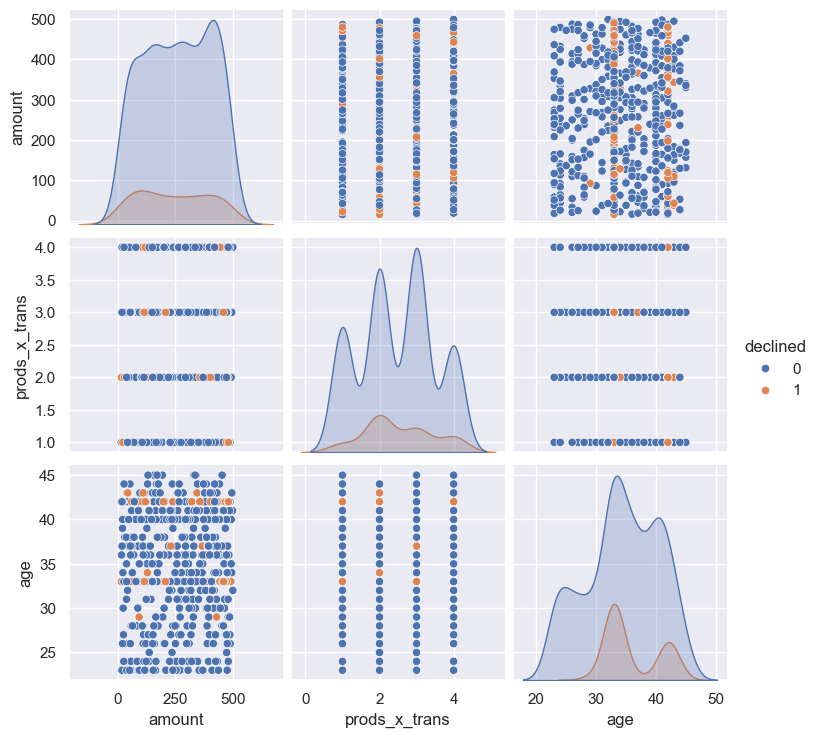

In [44]:
# Trazamos el pairplot
plt.figure(figsize=(10,5), layout='constrained')
sns.pairplot(df_transaction_user_products, vars=['amount', 'prods_x_trans', 'age'], hue='declined', diag_kind='kde')


Apreciamos que no hay una correlación entre el número de productos por transacción y el importe de la transacción. La edad de los usuarios más activos se sitúa entre los 30 y los 40 años.

Nivel 2

Ejercicio 1
Correlación de todas las variables numéricas

In [45]:
df_tr_pr.head()

,id,product_id
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,19
1,02C6201E-D90A-1859-B4EE-88D2986D3B02,1
2,02C6201E-D90A-1859-B4EE-88D2986D3B02,71
3,0466A42E-47CF-8D24-FD01-C0B689713128,43
4,0466A42E-47CF-8D24-FD01-C0B689713128,97


In [46]:
df_product.head()

,id,product_name,price,colour,wheight,warehouse_id
0,1,Direwolf Stannis,161.11,#7c7c7c,1.0,WH-4
1,10,Karstark Dorne,119.52,#f4f4f4,2.4,WH--5
2,100,south duel,40.43,#6d6d6d,3.0,WH--95
3,11,Karstark Dorne,49.70,#141414,2.7,WH--6
4,12,duel Direwolf,181.60,#a8a8a8,2.1,WH--7


In [47]:
df_product.rename(columns={'id': 'product_id'}, inplace=True)
df_tr_pr_weight = pd.merge(df_tr_pr, df_product, on='product_id', how='left')
df_tr_pr_weight.head()

,id,product_id,product_name,price,colour,wheight,warehouse_id
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,19,dooku solo,60.33,#3f3f3f,0.6,WH--14
1,02C6201E-D90A-1859-B4EE-88D2986D3B02,1,Direwolf Stannis,161.11,#7c7c7c,1.0,WH-4
2,02C6201E-D90A-1859-B4EE-88D2986D3B02,71,Tully Dorne,103.73,#424242,2.7,WH--66
3,0466A42E-47CF-8D24-FD01-C0B689713128,43,duel,59.80,#5b5b5b,0.6,WH--38
4,0466A42E-47CF-8D24-FD01-C0B689713128,97,jinn Winterfell,65.25,#bababa,1.0,WH--92


In [48]:
df_tr_pr_weight.describe()

,price,wheight
count,1457.000000,1457.0000
mean,105.669966,1.8407
std,54.923285,1.0557
min,9.240000,0.6000
25%,60.330000,1.0000
50%,103.730000,1.5000
75%,161.110000,2.7000
max,195.940000,3.2000


In [49]:
#Agrupamos por la id de la transacción para obtener el número de artículos y el peso total del envío
group_df_tr_pr_weight = df_tr_pr_weight.groupby('id')
group_df_tr_pr_weight.describe()

price                                 \
                                     count        mean        std     min   
id                                                                          
02C6201E-D90A-1859-B4EE-88D2986D3B02   3.0  108.390000  50.551348   60.33   
0466A42E-47CF-8D24-FD01-C0B689713128   3.0   69.066667  11.653576   59.80   
063FBA79-99EC-66FB-29F7-25726D1764A5   4.0  133.582500  58.619273   82.15   
0668296C-CDB9-A883-76BC-2E4C44F8C8AE   3.0  110.716667  75.607365   26.51   
06CD9AA5-9B42-D684-DDDD-A5E394FEBA99   2.0   72.410000  17.833233   59.80   
...                                    ...         ...        ...     ...   
FD2E8957-414B-BEEC-E9AD-59AA7A8A6290   4.0   88.627500  62.157956   26.51   
FD89D51B-AE8D-77DC-E450-B8083FBD3187   4.0  113.892500  74.067106    9.24   
FD9CBCCD-8E1E-8DA1-4606-7E3A6F3A5A65   1.0   26.660000        NaN   26.66   
FE809ED4-2DB6-55AC-C915-929516E4646B   2.0  114.880000  77.894883   59.80   
FE96CE47-BD59-381C-4E18-E3CA3D44E8FF   1.0  171.130000        NaN  171.13   

                                                                          \
                                           25%     50%       75%     max   
id                                                                         
02C6201E-D90A-1859-B4EE-88D2986D3B02   82.0300  103.73  132.4200  161.11   
0466A42E-47CF-8D24-FD01-C0B689713128   62.5250   65.25   73.7000   82.15   
063FBA79-99EC-66FB-29F7-25726D1764A5   84.3025  128.12  177.4000  195.94   
0668296C-CDB9-A883-76BC-2E4C44F8C8AE   79.6850  132.86  152.8200  172.78   
06CD9AA5-9B42-D684-DDDD-A5E394FEBA99   66.1050   72.41   78.7150   85.02   
...                                        ...     ...       ...     ...   
FD2E8957-414B-BEEC-E9AD-59AA7A8A6290   54.1250   77.61  112.1125  172.78   
FD89D51B-AE8D-77DC-E450-B8083FBD3187   87.8775  137.60  163.6150  171.13   
FD9CBCCD-8E1E-8DA1-4606-7E3A6F3A5A65   26.6600   26.66   26.6600   26.66   
FE809ED4-2DB6-55AC-C915-929516E4646B   87.3400  114.88  142.4200  169.96   
FE96CE47-BD59-381C-4E18-E3CA3D44E8FF  171.1300  171.13  171.1300  171.13   

                                     wheight                                  \
                                       count      mean       std  min    25%   
id                                                                             
02C6201E-D90A-1859-B4EE-88D2986D3B02     3.0  1.433333  1.115049  0.6  0.800   
0466A42E-47CF-8D24-FD01-C0B689713128     3.0  1.433333  1.115049  0.6  0.800   
063FBA79-99EC-66FB-29F7-25726D1764A5     4.0  1.775000  1.372042  0.6  0.600   
0668296C-CDB9-A883-76BC-2E4C44F8C8AE     3.0  2.166667  1.379613  0.6  1.650   
06CD9AA5-9B42-D684-DDDD-A5E394FEBA99     2.0  0.600000  0.000000  0.6  0.600   
...                                      ...       ...       ...  ...    ...   
FD2E8957-414B-BEEC-E9AD-59AA7A8A6290     4.0  2.425000  1.239287  0.6  2.175   
FD89D51B-AE8D-77DC-E450-B8083FBD3187     4.0  1.375000  0.478714  1.0  1.000   
FD9CBCCD-8E1E-8DA1-4606-7E3A6F3A5A65     1.0  1.000000       NaN  1.0  1.000   
FE809ED4-2DB6-55AC-C915-929516E4646B     2.0  1.650000  1.484924  0.6  1.125   
FE96CE47-BD59-381C-4E18-E3CA3D44E8FF     1.0  1.500000       NaN  1.5  1.500   

                                                        
                                       50%    75%  max  
id                                                      
02C6201E-D90A-1859-B4EE-88D2986D3B02  1.00  1.850  2.7  
0466A42E-47CF-8D24-FD01-C0B689713128  1.00  1.850  2.7  
063FBA79-99EC-66FB-29F7-25726D1764A5  1.65  2.825  3.2  
0668296C-CDB9-A883-76BC-2E4C44F8C8AE  2.70  2.950  3.2  
06CD9AA5-9B42-D684-DDDD-A5E394FEBA99  0.60  0.600  0.6  
...                                    ...    ...  ...  
FD2E8957-414B-BEEC-E9AD-59AA7A8A6290  2.95  3.200  3.2  
FD89D51B-AE8D-77DC-E450-B8083FBD3187  1.25  1.625  2.0  
FD9CBCCD-8E1E-8DA1-4606-7E3A6F3A5A65  1.00  1.000  1.0  
FE809ED4-2DB6-55AC-C915-929516E4646B  1.65  2.175  2.7  
FE96CE47-BD59-381C-4E18-E3CA3D4

In [50]:
type(group_df_tr_pr_weight)

pandas.core.groupby.generic.DataFrameGroupBy

In [51]:
# Vamos a reducir este dataframe a id, precio y peso antes de agregarlo a la tabla 'transaction'
df_tr_pr_weight_aggr = df_tr_pr_weight.pivot_table(index='id', values=['price', 'wheight'], aggfunc=['sum'])
df_tr_pr_weight_aggr

sum        
                                       price wheight
id                                                  
02C6201E-D90A-1859-B4EE-88D2986D3B02  325.17     4.3
0466A42E-47CF-8D24-FD01-C0B689713128  207.20     4.3
063FBA79-99EC-66FB-29F7-25726D1764A5  534.33     7.1
0668296C-CDB9-A883-76BC-2E4C44F8C8AE  332.15     6.5
06CD9AA5-9B42-D684-DDDD-A5E394FEBA99  144.82     1.2
...                                      ...     ...
FD2E8957-414B-BEEC-E9AD-59AA7A8A6290  354.51     9.7
FD89D51B-AE8D-77DC-E450-B8083FBD3187  455.57     5.5
FD9CBCCD-8E1E-8DA1-4606-7E3A6F3A5A65   26.66     1.0
FE809ED4-2DB6-55AC-C915-929516E4646B  229.76     3.3
FE96CE47-BD59-381C-4E18-E3CA3D44E8FF  171.13     1.5

[587 rows x 2 columns]

In [52]:
df_transaction_user_pr_wh = pd.merge(df_transaction_user_products, df_tr_pr_weight_aggr['sum'], on='id', how='left')
df_transaction_user_pr_wh.head()

,id,credit_card_id,company_id,timestamp,amount,declined,product_ids,user_id,latitude,longitude,...,birth_date,country,city,postal_code,address,age,full_name,prods_x_trans,price,wheight
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,CcU-2938,b-2362,2021-08-28 23:42:24,466.92,0,"71, 1, 19",92,81.9185,-12.5276,...,1984-09-21,United States,Bozeman,61871,"P.O. Box 712, 7907 Est St.",40,Lynn Riddle,3,325.17,4.3
1,0466A42E-47CF-8D24-FD01-C0B689713128,CcU-4219,b-2302,2021-07-26 07:29:18,49.53,0,"47, 97, 43",170,-43.9695,-117.5250,...,1987-05-15,United Kingdom,Coldstream,KY0 0DY,662-8112 Praesent Av.,37,William Benjamin,3,207.20,4.3
2,063FBA79-99EC-66FB-29F7-25726D1764A5,CcU-2987,b-2250,2022-01-06 21:25:27,92.61,0,"47, 67, 31, 5",275,-81.2227,-129.0500,...,1982-08-03,Canada,Richmond,R8H 2K2,8564 Facilisi. St.,42,Kenyon Hartman,4,534.33,7.1
3,0668296C-CDB9-A883-76BC-2E4C44F8C8AE,CcU-3743,b-2618,2022-01-26 02:07:14,394.18,0,"89, 83, 79",265,-34.3593,-100.5560,...,1999-01-10,Canada,Oliver,B5T 7L6,"P.O. Box 289, 3192 Cursus St.",26,Chloe Keith,3,332.15,6.5
4,06CD9AA5-9B42-D684-DDDD-A5E394FEBA99,CcU-2959,b-2346,2021-10-26 23:00:01,279.93,0,"43, 31",92,33.7381,158.2980,...,1984-09-21,United States,Bozeman,61871,"P.O. Box 712, 7907 Est St.",40,Lynn Riddle,2,144.82,1.2


In [53]:
#Nos quedamos con las variables numéricas:
df_transaction_user_pr_wh_subset = df_transaction_user_pr_wh[['amount', 'age', 'prods_x_trans', 'price', 'wheight']]
df_transaction_user_pr_wh_subset.head()

,amount,age,prods_x_trans,price,wheight
0,466.92,40,3,325.17,4.3
1,49.53,37,3,207.20,4.3
2,92.61,42,4,534.33,7.1
3,394.18,26,3,332.15,6.5
4,279.93,40,2,144.82,1.2


In [54]:
df_transaction_user_pr_wh_subset.corr()

,amount,age,prods_x_trans,price,wheight
amount,1.000000,0.036352,0.007070,0.017515,-0.011021
age,0.036352,1.000000,0.008542,0.030241,0.018467
prods_x_trans,0.007070,0.008542,1.000000,0.776632,0.744327
price,0.017515,0.030241,0.776632,1.000000,0.669312
wheight,-0.011021,0.018467,0.744327,0.669312,1.000000


<Axes: >

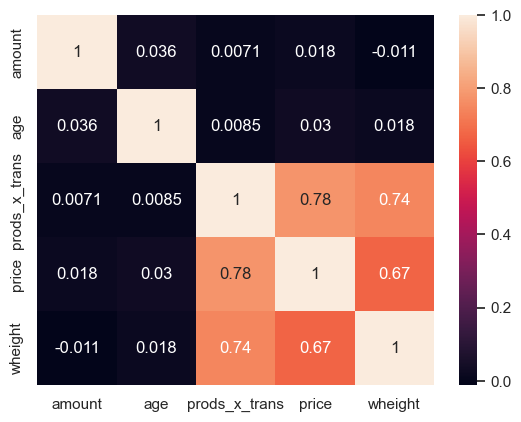

In [55]:
sns.heatmap(df_transaction_user_pr_wh_subset[['amount','age','prods_x_trans','price', 'wheight']].corr(), annot=True)

Vemos que hay una correlación (bastante lógica) entre el valor de la transacción, el número de productos por transacción (con un valor no muy elevado, dada la dispersión de precios), el precio de cada producto (la correlación es relativamente baja, dada los descuentos o recargos aplicados a los usuarios) y con el peso.

Ejercicio 2

Implementa un jointplot.

In [56]:
df_transaction_user_pr_wh.describe()

,timestamp,amount,declined,latitude,longitude,birth_date,age,prods_x_trans,price,wheight
count,587,587.000000,587.000000,587.000000,587.000000,587,587.000000,587.000000,587.000000,587.000000
mean,2021-09-06 14:56:16.795570688,256.735520,0.148211,0.672389,-4.469083,1990-01-05 10:45:10.732538368,34.608177,2.482112,262.284736,4.568825
min,2021-03-17 02:55:49,15.050000,0.000000,-89.824800,-179.366000,1979-04-30 00:00:00,23.000000,1.000000,9.240000,0.600000
25%,2021-06-02 05:14:58.500000,131.115000,0.000000,-44.024000,-98.952450,1984-09-21 00:00:00,32.000000,2.000000,167.520000,3.200000
50%,2021-08-27 10:25:34,257.440000,0.000000,1.402780,-5.964040,1991-04-16 00:00:00,33.000000,2.000000,247.670000,4.300000
75%,2021-12-13 08:24:48,389.900000,0.000000,44.870100,88.348400,1992-07-24 12:00:00,40.000000,3.000000,356.445000,6.200000
max,2022-03-16 14:01:36,499.230000,1.000000,89.921200,179.950000,2001-02-19 00:00:00,45.000000,4.000000,643.210000,12.300000
std,NaN,144.133895,0.355612,51.485399,106.625421,NaN,5.848176,0.986740,130.119106,2.370683


In [57]:
df_transaction_user_pr_wh

,id,credit_card_id,company_id,timestamp,amount,declined,product_ids,user_id,latitude,longitude,...,birth_date,country,city,postal_code,address,age,full_name,prods_x_trans,price,wheight
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,CcU-2938,b-2362,2021-08-28 23:42:24,466.92,0,"71, 1, 19",92,81.91850,-12.5276,...,1984-09-21,United States,Bozeman,61871,"P.O. Box 712, 7907 Est St.",40,Lynn Riddle,3,325.17,4.3
1,0466A42E-47CF-8D24-FD01-C0B689713128,CcU-4219,b-2302,2021-07-26 07:29:18,49.53,0,"47, 97, 43",170,-43.96950,-117.5250,...,1987-05-15,United Kingdom,Coldstream,KY0 0DY,662-8112 Praesent Av.,37,William Benjamin,3,207.20,4.3
2,063FBA79-99EC-66FB-29F7-25726D1764A5,CcU-2987,b-2250,2022-01-06 21:25:27,92.61,0,"47, 67, 31, 5",275,-81.22270,-129.0500,...,1982-08-03,Canada,Richmond,R8H 2K2,8564 Facilisi. St.,42,Kenyon Hartman,4,534.33,7.1
3,0668296C-CDB9-A883-76BC-2E4C44F8C8AE,CcU-3743,b-2618,2022-01-26 02:07:14,394.18,0,"89, 83, 79",265,-34.35930,-100.5560,...,1999-01-10,Canada,Oliver,B5T 7L6,"P.O. Box 289, 3192 Cursus St.",26,Chloe Keith,3,332.15,6.5
4,06CD9AA5-9B42-D684-DDDD-A5E394FEBA99,CcU-2959,b-2346,2021-10-26 23:00:01,279.93,0,"43, 31",92,33.73810,158.2980,...,1984-09-21,United States,Bozeman,61871,"P.O. Box 712, 7907 Est St.",40,Lynn Riddle,2,144.82,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,FD2E8957-414B-BEEC-E9AD-59AA7A8A6290,CcU-3232,b-2390,2022-03-13 00:27:34,78.29,0,"83, 7, 17, 89",272,-24.31950,-11.4135,...,1991-04-16,Canada,Tuktoyaktuk,Q4C 3G7,"P.O. Box 496, 5145 Sapien Road",33,Hedwig Gilbert,4,354.51,9.7
583,FD89D51B-AE8D-77DC-E450-B8083FBD3187,CcU-3960,b-2494,2022-03-16 02:35:05,200.72,0,"3, 2, 73, 1",250,8.01217,-64.6715,...,1994-12-21,Canada,Baddeck,B4R 5C5,"P.O. Box 306, 6953 At Street",30,Hilda Levy,4,455.57,5.5
584,FD9CBCCD-8E1E-8DA1-4606-7E3A6F3A5A65,CcU-4331,b-2302,2021-06-13 11:41:17,42.32,0,37,223,-77.86050,-172.3460,...,1992-03-23,Canada,Lourdes,B0R 4L1,6491 Cursus St.,32,Linus Willis,1,26.66,1.0
585,FE809ED4-2DB6-55AC-C915-929516E4646B,CcU-4849,b-2302,2021-11-09 21:35:40,219.83,0,"23, 43",185,-46.07510,-142.2420,...,1993-12-21,United Kingdom,Banchory,U8H 7PH,"P.O. Box 202, 5638 Mi Rd.",31,Molly Gilliam,2,229.76,3.3


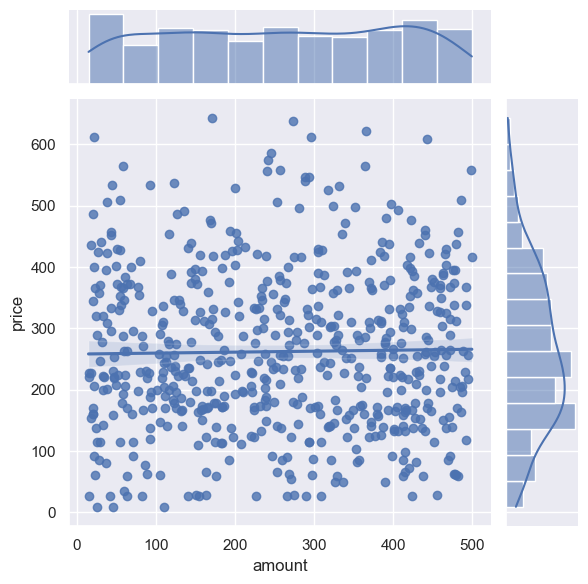

In [58]:
sns.jointplot(data=df_transaction_user_pr_wh, x='amount', y='price', kind='reg')

Vemos que no hay relación entre el importe de la transacción y la suma del precio de los productos. Percibimos que existen bastantes transacciones con importe bajo (menos de cincuenta euros), y que se acostumbra a realizar pedidos de productos cuyo precio total de venta se sitúa entre los 150 y 250 dólares.

Nivel 3

Ejercicio 1

Implementa un violinplot combinado con otro tipo de gráfica.

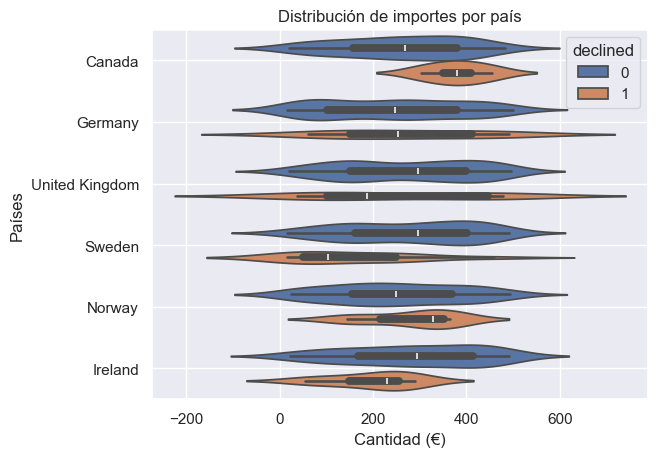

In [59]:
# Graficamos el violinplot. Vemos que nos incluye el boxplot:
ax = sns.violinplot(y=df_transaction_country_top['country'], x=df_transaction_country_top['amount'], hue=df_transaction_country_top['declined'])
plt.title('Distribución de importes por país')

ax.set_xlabel('Cantidad (€)')
ax.set_ylabel('Países')

ax.grid(axis='y')
ax.set_axisbelow(True)


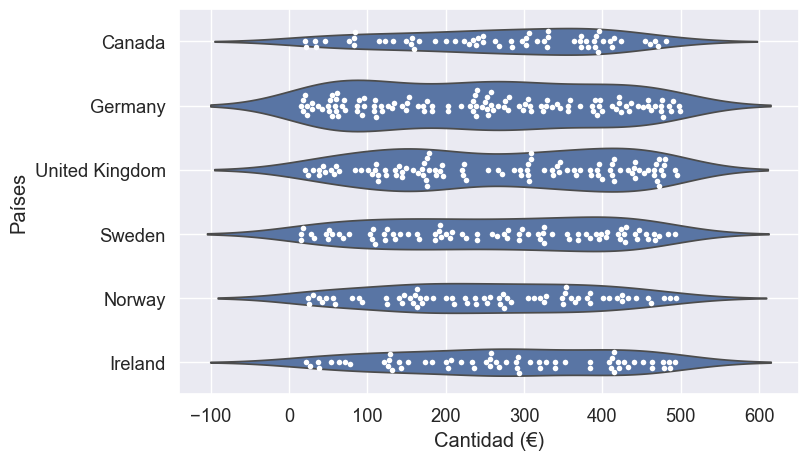

In [60]:
#Vamos a añadir un swarmplot por encima para situar los valores de las transacciones

# Creamos la figura:
sns.set_context('notebook', font_scale=1.2)
fig, ax = plt.subplots(figsize=(8,5))

# Dibujamos el violin
ax = sns.violinplot(y="country", 
                  x="amount", 
                  data=df_transaction_country_top,
                  density_norm='count',
                  inner=None
              )
              

# Situamos por encima el swarmplot 
ax = sns.swarmplot(y="country",
                   x="amount",
                   data=df_transaction_country_top,
                   color="white", 
                   edgecolor="auto",
                   s=4, # Circle size
             )


ax.set_xlabel('Cantidad (€)')
ax.set_ylabel('Países')


ax.grid(axis='y')
ax.set_axisbelow(True)

Percibimos la importancia de Alemania y Reino Unido en número de transacciones realizadas. Nos interesaría poner en marcha acciones en Alemania para aumentar el importe de las transacciones más baratas.

Ejercicio 2

Genera un FacetGrid para visualizar múltiples aspectos de los datos simultáneamente.

Vamos a ver la evolución de las transacciones por periodo.

In [74]:
df_transaction_user_pr_wh['period'] = df_transaction_user_pr_wh['timestamp'].dt.to_period('M')
df_transaction_user_pr_wh['month'] = df_transaction_user_pr_wh['timestamp'].dt.month
df_transaction_user_pr_wh['year'] = df_transaction_user_pr_wh['timestamp'].dt.year
df_transaction_user_pr_wh.head()

,id,credit_card_id,company_id,timestamp,amount,declined,product_ids,user_id,latitude,longitude,...,postal_code,address,age,full_name,prods_x_trans,price,wheight,period,month,year
0,02C6201E-D90A-1859-B4EE-88D2986D3B02,CcU-2938,b-2362,2021-08-28 23:42:24,466.92,0,"71, 1, 19",92,81.9185,-12.5276,...,61871,"P.O. Box 712, 7907 Est St.",40,Lynn Riddle,3,325.17,4.3,2021-08,8,2021
1,0466A42E-47CF-8D24-FD01-C0B689713128,CcU-4219,b-2302,2021-07-26 07:29:18,49.53,0,"47, 97, 43",170,-43.9695,-117.5250,...,KY0 0DY,662-8112 Praesent Av.,37,William Benjamin,3,207.20,4.3,2021-07,7,2021
2,063FBA79-99EC-66FB-29F7-25726D1764A5,CcU-2987,b-2250,2022-01-06 21:25:27,92.61,0,"47, 67, 31, 5",275,-81.2227,-129.0500,...,R8H 2K2,8564 Facilisi. St.,42,Kenyon Hartman,4,534.33,7.1,2022-01,1,2022
3,0668296C-CDB9-A883-76BC-2E4C44F8C8AE,CcU-3743,b-2618,2022-01-26 02:07:14,394.18,0,"89, 83, 79",265,-34.3593,-100.5560,...,B5T 7L6,"P.O. Box 289, 3192 Cursus St.",26,Chloe Keith,3,332.15,6.5,2022-01,1,2022
4,06CD9AA5-9B42-D684-DDDD-A5E394FEBA99,CcU-2959,b-2346,2021-10-26 23:00:01,279.93,0,"43, 31",92,33.7381,158.2980,...,61871,"P.O. Box 712, 7907 Est St.",40,Lynn Riddle,2,144.82,1.2,2021-10,10,2021


In [68]:
df_transaction_user_pr_wh.dtypes

id                        object
credit_card_id            object
company_id                object
timestamp         datetime64[ns]
amount                   float64
declined                   int64
product_ids               object
user_id                   object
latitude                 float64
longitude                float64
name                      object
surname                   object
phone                     object
email                     object
birth_date        datetime64[ns]
country                   object
city                      object
postal_code               object
address                   object
age                        int64
full_name                 object
prods_x_trans              int64
price                    float64
wheight                  float64
period                 period[M]
month                      int32
year                       int32
dtype: object

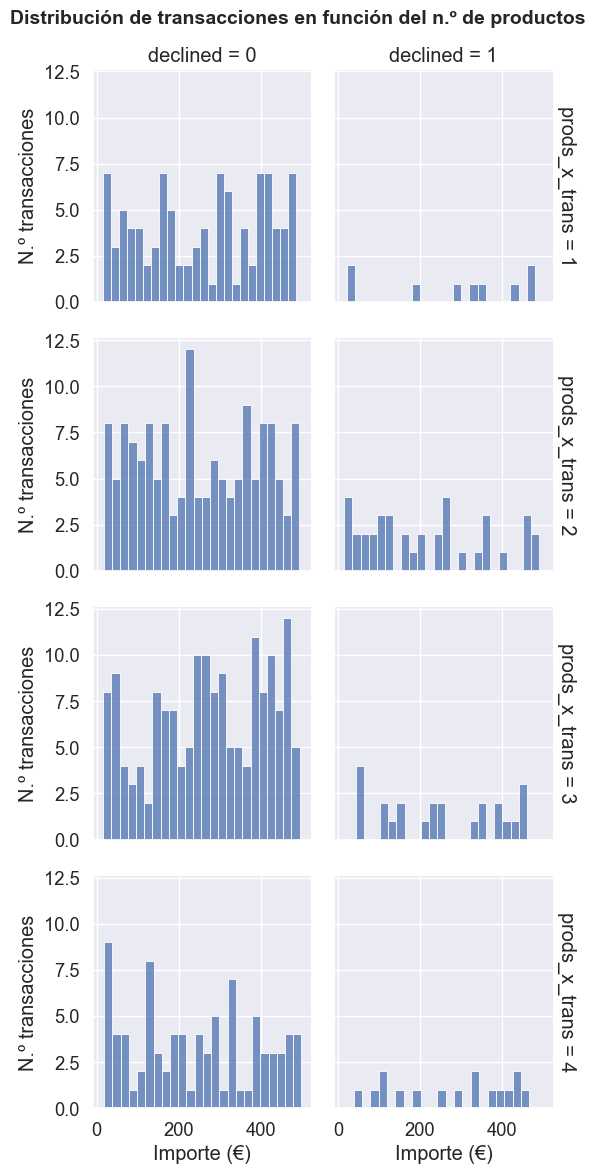

In [104]:
g = sns.FacetGrid(df_transaction_user_pr_wh, col='declined', row='prods_x_trans', margin_titles=True)
g.map_dataframe(sns.histplot, x='amount', binwidth=20)
g.fig.suptitle("Distribución de transacciones en función del n.º de productos", fontsize=14, fontweight='bold')
g.fig.subplots_adjust(top=.93)
g.set_axis_labels('Importe (€)', 'N.º transacciones')
#g.set_titles(fontsize='small')

Vemos que los pedidos con cuatro artículos no son muy habituales, y que, curiosamente, se repiten más en transacciones con menos ingresos, ya sea por compras esporádicas de clientes que se deciden por artículos más baratos, o bien por parte de clientes con grandes descuentos.